Loading LFW dataset...
Identifying images of class: George_W_Bush
 LFW dataset loaded and preprocced from directory
 Bottelneck Dimension Analysis -- 3.2.2
DEBUG: Creating MLPAutoencoder with input_dim=4096 and latent_dim=8
Training autoencoder with bottelneck dim:8
Epoch 10/150, Loss: 0.074848
Epoch 20/150, Loss: 0.055451
Epoch 30/150, Loss: 0.048500
Epoch 40/150, Loss: 0.045891
Epoch 50/150, Loss: 0.044694
Epoch 60/150, Loss: 0.043625
Epoch 70/150, Loss: 0.043351
Epoch 80/150, Loss: 0.042795
Epoch 90/150, Loss: 0.042239
Epoch 100/150, Loss: 0.041316
Epoch 110/150, Loss: 0.040441
Epoch 120/150, Loss: 0.039676
Epoch 130/150, Loss: 0.038810
Epoch 140/150, Loss: 0.037843
Epoch 150/150, Loss: 0.036500
DEBUG: Creating MLPAutoencoder with input_dim=4096 and latent_dim=32
Training autoencoder with bottelneck dim:32
Epoch 10/150, Loss: 0.073531
Epoch 20/150, Loss: 0.054425
Epoch 30/150, Loss: 0.048160
Epoch 40/150, Loss: 0.045583
Epoch 50/150, Loss: 0.044495
Epoch 60/150, Loss: 0.043682
Epoch

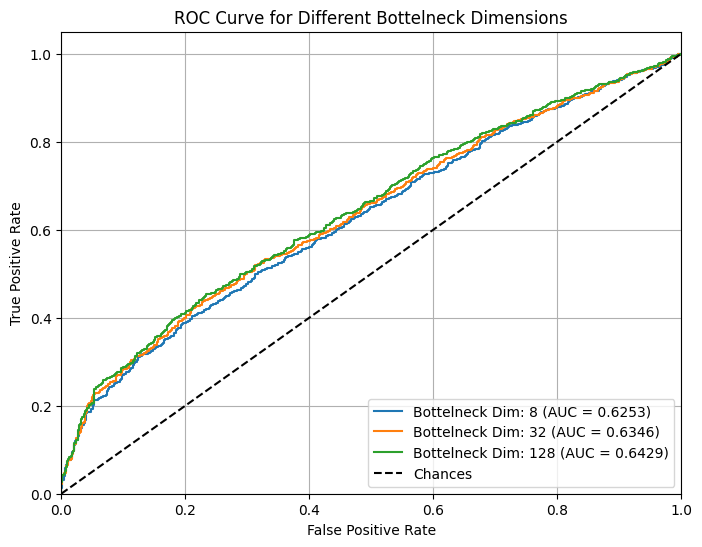

Best Bottelneck Dimension: 128
 ANomoly Detection Evaluation part 3.2.1
Best threshold found:  0.005971
AUC Score: 0.6429
Precision: 0.9599
Recall: 0.9999
F1 Score: 0.9795
 Anomaly Detection Visualization -- 3.2.2


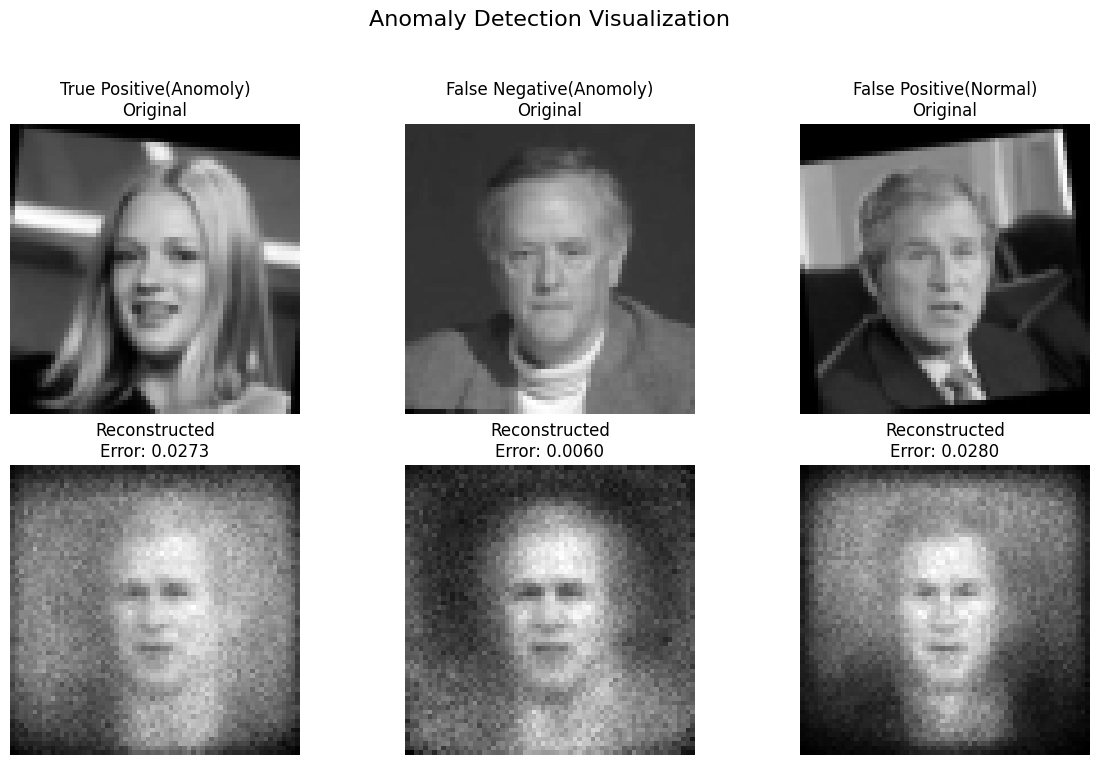

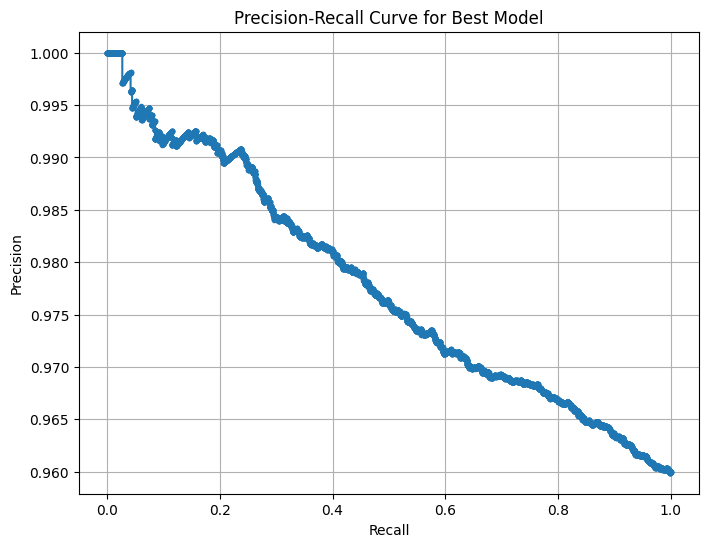

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve ,auc , precision_recall_curve ,f1_score ,precision_score,recall_score
from skimage.transform import resize
from skimage.color import rgb2gray
from PIL import Image
import os

class Module:

  def __init__(self):
    self._parameters = {}
    self._gradients = {}
    self.training = True

  def forward(self , *args , **kwargs):
    raise NotImplementedError

  def backward(self , *args , **kwargs):
    raise NotImplementedError

  def parameters(self):

    params = []
    for name , param in self._parameters.items():
        if param is not None:
          params.append(param)

    for attr_name in dir(self):
        attr = getattr(self , attr_name)
        if isinstance(attr , Module):
          params.extend(attr.parameters())
    return params

  def gradients(self):
    grads = []
    for name , grad in self._gradients.items():
      if grad is not None:
        grads.append(grad)

    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        grads.extend(attr.gradients())
    return grads

  def train(self):

    self.training = True
    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        attr.train()

  def eval(self):

    self.training = False
    for attr_name in dir(self):
      attr = getattr(self , attr_name)
      if isinstance(attr , Module):
        attr.eval()

class Linear(Module):

  def __init__(self, in_features , out_features , bias = True):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features

    limit = np.sqrt(6 / (in_features + out_features))
    self.weights = np.random.uniform(-limit , limit , (in_features ,out_features))
    self._parameters['weights'] = self.weights
    self._gradients['weights'] = np.zeros_like(self.weights)


    self.bias = None
    if bias:
      self.bias = np.zeros(out_features)
      self._parameters['bias'] = self.bias
      self._gradients['bias'] = np.zeros_like(self.bias)

    self.input = None

  def forward(self , x):
    self.input = x
    output = x @ self.weights
    if self.bias is not None:
      output += self.bias
    return output

  def backward(self , grad_output):
    self._gradients['weights'] = self.input.T @ grad_output
    if self.bias is not None:
      self._gradients['bias'] = np.sum(grad_output , axis = 0)

    grad_input = grad_output @ self.weights.T
    return grad_input

class Sequential(Module):

  def __init__(self , *layers):
    super().__init__()
    self.layers = list(layers)
    for i , layer in enumerate(self.layers):
      setattr(self , f'layer_{i}' , layer)

  def forward(self , x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self , grad_output):
    for layer in reversed(self.layers):
      grad_output = layer.backward(grad_output)
    return grad_output


class ReLU(Module):

  def __init__(self):
    super().__init__()
    self.input = None

  def forward(self , x):
    self.input = x
    return np.maximum(0,x)

  def backward(self , grad_output):
    return np.multiply(grad_output , self.input > 0)

class Sigmoid(Module):

  def __init__(self):
    super().__init__()
    self.input = None

  def forward(self , x):
    self.output = 1 / (1 + np.exp(-x))
    return self.output

  def backward(self , grad_output):
    return np.multiply(grad_output , self.output * (1 - self.output))


class MSELoss(Module):

  def __init__(self):
    super().__init__()
    self.pred = None
    self.target = None

  def forward(self , pred , target):
    self.pred = pred
    self.target = target
    return np.mean((pred - target) ** 2)

  def backward(self , grad_output):
    n = self.target.shape[0] * self.target.shape[1]
    grad_input =  2 * (self.pred - self.target) / n
    return grad_input

class Adam:

  def __init__(self , params ,lr = 0.001 , beta1 = 0.9 , beta2 = 0.999 , epsilon = 1e-8):

    self.params = [p for p in params]
    self.grads = [np.zeros_like(p) for p in self.params]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.t = 0

    self.m = [np.zeros_like(p) for p in self.params]
    self.v = [np.zeros_like(p) for p in self.params]

  def zero_grad(self):
    for g in self.grads:
      g.fill(0)

  def step(self , model_grads):

    self.t += 1
    for i , (param, grad) in enumerate(zip(self.params ,model_grads)):
      self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
      self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

      m_hat = self.m[i] / (1 - self.beta1 ** self.t)
      v_hat = self.v[i] / (1 - self.beta2 ** self.t)

      # Fix: Use self.params[i] to update the parameter in place
      self.params[i] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)


class MLPAutoencoder(Module):

  def __init__(self , input_dim = 784,latent_dim= 64):

    super().__init__()

    self.encoder = Sequential(
      Linear(input_dim , 256),
      ReLU(),
      Linear(256 , 128),
      ReLU(),
      Linear(128 , latent_dim)
    )

    self.decoder = Sequential(
      Linear(latent_dim , 128),
      ReLU(),
      Linear(128 , 256),
      ReLU(),
      Linear(256 , input_dim),
      Sigmoid()
    )


  def forward(self , x):
    encoded = self.encoder.forward(x)
    # Fix: Pass the encoded output to the decoder
    decoded = self.decoder.forward(encoded)
    return decoded

  def backward(self , grad_output):
    grad_encoded = self.decoder.backward(grad_output)
    grad_input = self.encoder.backward(grad_encoded)
    return grad_input


def load_and_prep_mnist():

  print("Loading MNIST dataset")
  mnist = fetch_openml('mnist_784', version=1 ,as_frame = False, parser = 'auto')
  X = mnist.data.astype('float32')
  y = mnist.target.astype('int64')

  print("Normalizing data")
  X /= 255.0

  print("Splitting data into train and test sets")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test


def train_autoencoder(model , X_train , epochs = 20 , batch_size = 256 , lr = 1e-3):

  criterion = MSELoss()
  optimizer = Adam(model.parameters() , lr = lr)

  model.train() # Fix: Corrected typo from model.tarin() to model.train()

  n_samples = X_train.shape[0]
  n_batches = n_samples // batch_size

  for epoch in range(epochs):
    epoch_loss = 0.0

    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train[permutation]

    for i in range(n_batches):
      start_idx = i * batch_size
      end_idx = start_idx + batch_size

      X_batch = X_train_shuffled[start_idx : end_idx]

      reconstructed  = model.forward(X_batch)
      loss = criterion.forward(reconstructed , X_batch)

      grad_input = criterion.backward(1.0) # Fix: Added a placeholder grad_output of 1.0
      model.backward(grad_input)

      optimizer.step(model.gradients())
      optimizer.zero_grad()

      epoch_loss += loss

    avg_loss = epoch_loss / n_batches
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")


def visualize_reconstructions(model , X_test , y_test):

  model.eval()

  fig,axes = plt.subplots(10,2,figsize = (5,15))
  fig.suptitle("Original vs Reconstructed Images" , fontsize = 16)

  for i in range(10):

    digit_idx = np.where(y_test == i)[0][0]
    original_img = X_test[digit_idx]

    original_img_batch = original_img.reshape(1,-1)

    reconstructed_img = model.forward(original_img_batch).flatten()

    axes[i,0].imshow(original_img.reshape(28,28) , cmap = 'gray')
    axes[i,0].set_title(f"Original: {i}")
    axes[i,0].axis('off')

    axes[i,1].imshow(reconstructed_img.reshape(28,28) , cmap = 'gray')
    axes[i,1].set_title(f"Reconstructed: {i}")
    axes[i,1].axis('off')


  plt.tight_layout(rect = [0 , 0.03 ,1,0.97])
  plt.show()


def load_and_prep_lfw(lfw_dataset_path , img_size = (64,64)):

  print("Loading LFW dataset...")

  images_raw = []
  labels_str = []

  target_names = sorted([d for d in os.listdir(lfw_dataset_path) if os.path.isdir(os.path.join(lfw_dataset_path , d))])
  label_map = {name : i for i , name in enumerate(target_names)}

  for person_name in target_names:
    person_dir = os.path.join(lfw_dataset_path , person_name)

    if not os.path.isdir(person_dir):
      continue

    for img_file in os.listdir(person_dir):
      img_path = os.path.join(person_dir , img_file)
      try:

        img = Image.open(img_path)
        images_raw.append(np.array(img))
        labels_str.append(person_name)

      except Exception as e:
        print(f"Error loading image {img_path}: {e}")

  X_processed = []
  for img in images_raw:
    img_resized = resize(img, img_size ,anti_aliasing=True)
    if len(img_resized.shape) == 3:
      img_resized = rgb2gray(img_resized)
    X_processed.append(img_resized)

  X_processed = np.array(X_processed).astype('float32')

  X_processed = (X_processed - np.min(X_processed)) / (np.max(X_processed) - np.min(X_processed))

  n_samples = X_processed.shape[0]
  X_processed = X_processed.reshape(n_samples, -1)

  normal_class_name = 'George_W_Bush'
  print(f"Identifying images of class: {normal_class_name}")

  normal_class_label_id = label_map[normal_class_name]

  y = np.array([label_map[name] for name in labels_str])

  X_train = X_processed[y == normal_class_label_id]

  X_test = X_processed

  y_test_anomly = (y != normal_class_label_id).astype(int)

  print(" LFW dataset loaded and preprocced from directory")
  return X_train , X_test , y_test_anomly ,img_size


def train_lfw_autoencoder(X_train ,input_dim ,latent_dim = 32 , epochs = 150 , batch_size = 32 , lr = 1e-5):

  model = MLPAutoencoder(input_dim , latent_dim)

  criterion = MSELoss()
  optimizer = Adam(model.parameters() , lr = lr)

  model.train()

  n_samples = X_train.shape[0]
  n_batches = n_samples // batch_size

  print(f"Training autoencoder with bottelneck dim:{latent_dim}")
  for epoch in range(epochs):
    epoch_loss = 0.0
    permutation = np.random.permutation(n_samples)
    X_train_shuffled = X_train[permutation]

    for i in range(n_batches):
      start_idx = i * batch_size
      end_idx = (i+1)*batch_size

      X_batch = X_train_shuffled[start_idx : end_idx]
      reconstructed = model.forward(X_batch)
      loss = criterion.forward(reconstructed , X_batch)
      grad_input = criterion.backward(1.0)
      model.backward(grad_input)
      optimizer.step(model.gradients())
      optimizer.zero_grad()

      epoch_loss += loss


    if (epoch+1) % 10 == 0:
      avg_loss = epoch_loss / n_batches
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")

  return model


def evaluate_anomoly_detection(model , X_test , y_test):

  model.eval()
  errors =[]
  for i in range(X_test.shape[0]):
    img = X_test[i].reshape(1,-1)
    reconstructed = model.forward(img)
    error = np.mean((img - reconstructed) ** 2)
    errors.append(error)
  return np.array(errors)


def part_3_2_1(model , errors, y_test):

  print(" ANomoly Detection Evaluation part 3.2.1")

  precisions , recalls , thresholds = precision_recall_curve(y_test , errors)
  f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-8)
  best_threshold = thresholds[np.argmax(f1_scores)]
  print(f"Best threshold found: {best_threshold: .6f}")

  y_pred = (errors > best_threshold).astype(int)

  auc_score = auc(*roc_curve(y_test , errors)[:2])
  precision = precision_score(y_test , y_pred)
  recall = recall_score(y_test , y_pred)
  f1 = f1_score(y_test , y_pred)

  print(f"AUC Score: {auc_score:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  return best_threshold


def part_3_2_2_analysis(X_train , X_test , y_test , input_dim):

  print(" Bottelneck Dimension Analysis -- 3.2.2")
  bottelneck_dims = [8 , 32 , 128]
  plt.figure(figsize=(8,6) )

  models = {}

  for dim in bottelneck_dims:
    model = train_lfw_autoencoder(X_train , input_dim , latent_dim = dim)
    errors = evaluate_anomoly_detection(model , X_test , y_test)
    models[dim] = (model, errors)

    fpr , tpr,_ = roc_curve(y_test, errors)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr , tpr , label = f"Bottelneck Dim: {dim} (AUC = {roc_auc:.4f})")

  plt.plot([0,1] , [0,1] , 'k--' , label = 'Chances')
  plt.xlim([0.0 , 1.0])
  plt.ylim([0.0 , 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Different Bottelneck Dimensions')
  plt.legend(loc = 'lower right')
  plt.grid()
  plt.show()

  best_dim  = max(models , key= lambda d:auc(*roc_curve(y_test, models[d][1])[:2]))
  print(f"Best Bottelneck Dimension: {best_dim}")

  return models[best_dim][0] ,models[best_dim][1]


def part_3_2_2_visualization(model , X_test , y_test , errors, threshold , img_shape):

  print(" Anomaly Detection Visualization -- 3.2.2")

  y_pred = (errors > threshold).astype(int)

  tn_indices = np.where((y_test == 0) & (y_pred == 0))[0]
  tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]
  fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
  fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]

  indices = []
  titles = []

  if len(tn_indices) > 0:
    indices.append(tn_indices[0])
    titles.append("True Negative(Normal)")

  if len(tp_indices) > 0:
    indices.append(tp_indices[0])
    titles.append("True Positive(Anomoly)")

  if len(fn_indices) > 0:
    indices.append(fn_indices[0])
    titles.append("False Negative(Anomoly)")

  if len(fp_indices) > 0:
    indices.append(fp_indices[0])
    titles.append("False Positive(Normal)")


  if not indices:
    print("Could not find examples for all visualisation categories.")
    return

  fig , axes = plt.subplots(2,len(indices) , figsize = (4* len(indices) ,8))
  fig.suptitle("Anomaly Detection Visualization" , fontsize = 16)

  if len(indices) == 1:
    axes = axes.reshape(2,1)

  for i ,(idx, title) in enumerate(zip(indices , titles)):
    original_img = X_test[idx]
    reconstructed_img = model.forward(original_img.reshape(1,-1)).flatten()
    error = errors[idx]

    ax = axes[0,i]
    ax.imshow(original_img.reshape(img_shape) , cmap = 'gray')
    ax.set_title(f"{title}\nOriginal")
    ax.axis('off')

    ax= axes[1,i]
    ax.imshow(reconstructed_img.reshape(img_shape) , cmap = 'gray')
    ax.set_title(f"Reconstructed\nError: {error:.4f}")
    ax.axis('off')

  plt.tight_layout(rect = [0,0.03,1,0.95])
  plt.show()

  precision , recall , _ = precision_recall_curve(y_test , errors)
  plt.figure(figsize = (8,6))
  plt.plot(recall , precision , marker = ".")
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve for Best Model')
  plt.grid()
  plt.show()


if __name__ == "__main__":

  lfw_dataset_path = "/content/LFW_Dataset"

  X_train_lfw , X_test_lfw , y_test_lfw , img_size = load_and_prep_lfw(lfw_dataset_path)

  input_dim_lfw = img_size[0] * img_size[1]

  best_model , best_errors = part_3_2_2_analysis(X_train_lfw , X_test_lfw , y_test_lfw , input_dim_lfw)

  best_threshold = part_3_2_1(best_model , best_errors , y_test_lfw)
  part_3_2_2_visualization(best_model , X_test_lfw , y_test_lfw , best_errors , best_threshold , img_size)